# [Air Passengers](https://www.kaggle.com/chirag19/air-passengers)
대표적인 시계열 사용 주제
- 비즈니스 예측 및 과거의 데이터로 미래 예측

대표적인 시계열 사용불가 주제
- Y값이 constant 한 경우
- 수학적인 공식으로 표현 가능한 경우 ex)y=sin(x)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DongChanKIM2/Kaggle_Struggle/blob/main/**Air-Passengers**.ipynb)

## 라이브러리 생성

In [ ]:
from datetime import datetime # time 생성하기 위해서
import numpy as np #for numerical computations like log,exp,sqrt etc
import pandas as pd #for reading & storing data, pre-processing
import matplotlib.pylab as plt
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline 
from statsmodels.tsa.stattools import adfuller # 시계열 예측 검증
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA # ARIMA 시계열 예측
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [ ]:
path="C:/Users/New20/OneDrive/Desktop/kaggle/시계열예측/AirPassengers.csv"
dataset=pd.read_csv(path)

In [ ]:
dataset.dtypes

Month          object
#Passengers     int64
dtype: object

## 시간을 X축으로 기준(Passenger는 Y축으로 자동지정)

In [ ]:
dataset['Month']=pd.to_datetime(dataset['Month'],infer_datetime_format=True)
indexedDataset=dataset.set_index(['Month'])
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
dataset.dtypes

Month          datetime64[ns]
#Passengers             int64
dtype: object

Text(0, 0.5, 'Number of Air passengers')

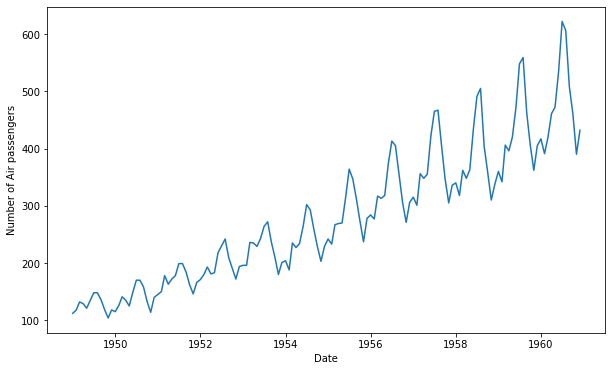

In [ ]:
# 매년 이용 고객이 늘어나는 추세임을 확인
plt.plot(indexedDataset)
plt.xlabel('Date')
plt.ylabel('Number of Air passengers')

1년 단위로 계산하면 연별 추세 및 평균값을 더 정확하게 구할 수 있음(11행까지는 NAN)

In [ ]:
rolmean=indexedDataset.rolling(window=12).mean()
rolstd=indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01   463.333333
1960-09-01   467.083333
1960-10-01   471.583333
1960-11-01   473.916667
1960-12-01   476.166667

[144 rows x 1 columns]             #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
...                 ...
1960-08-01    83.630500
1960-09-01    84.617276
1960-10-01    82.541954
1960-11-01    79.502382
1960-12-01    77.737125

[144 rows x 1 columns]


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

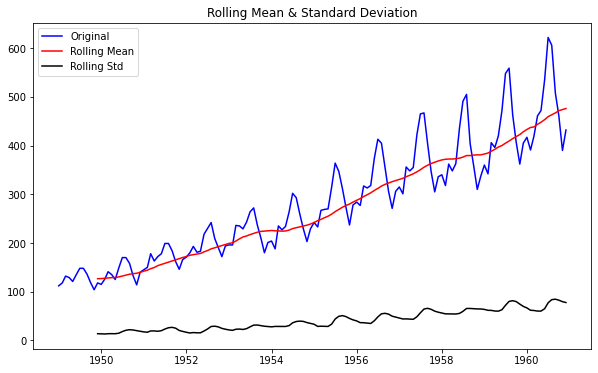

In [ ]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

시계열 예측을 하기 위해선 mean, std가 x축에 평행해야하는데 mean이 평행하지 않기에 적용하기 힘듬. 

In [ ]:
#Perform Augmented Dickey-Fuller Test:
print('Results of ADF Test:')
dftest=adfuller(indexedDataset['#Passengers'], autolag='AIC') #default: AIC
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
'#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

#Result of DICKEY Fuller Test

Results of ADF Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


To be Time Series:
1. p-value가 매우 낮거나
2. Test statistics가 critical보다 작은 값
두 가지 조건 모두 충족을 못하므로  
stationary 하지 못함

stationarity를 위해 3가지 방법 중 선택  
1. log scale로 변환
2. 지수
3. time shift

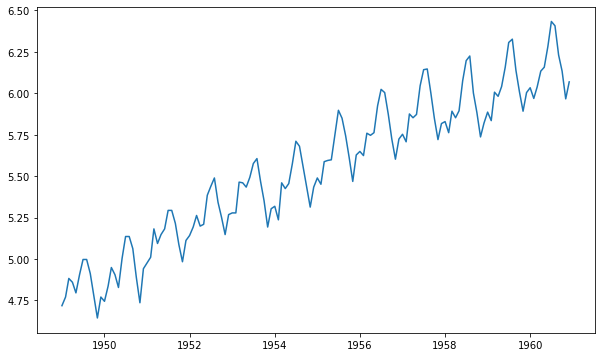

In [ ]:
indexedDataset_logScale=np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

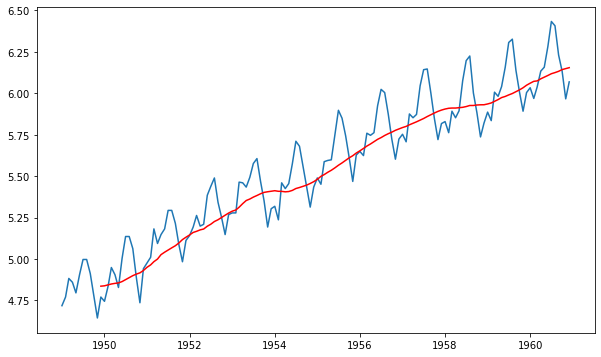

In [ ]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

## Exponential Decay Transformation

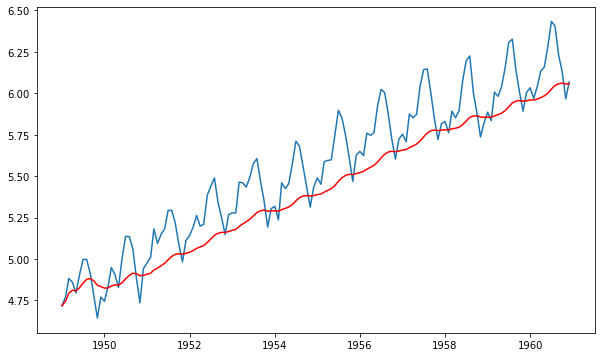

In [ ]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

Results of Dickey Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


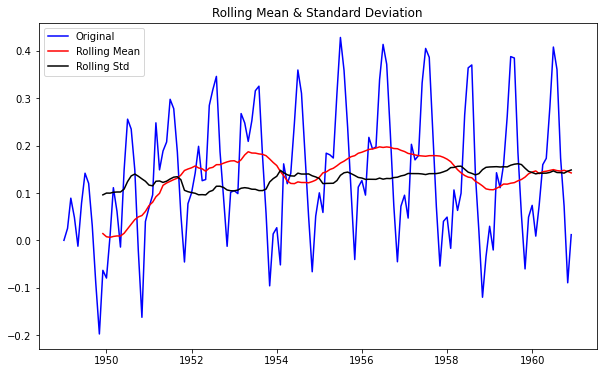

In [ ]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage

datasetLogScaleMinusExponentialMovingAverage.head()
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

## 3. time shift Transformation

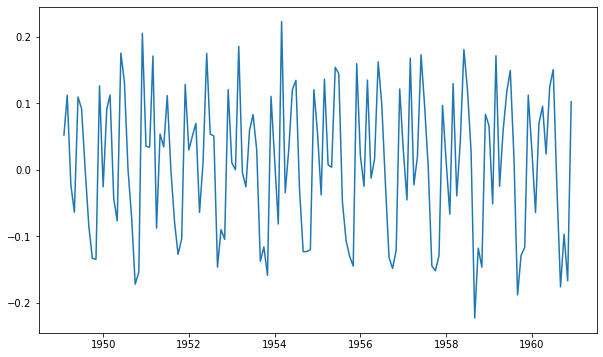

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


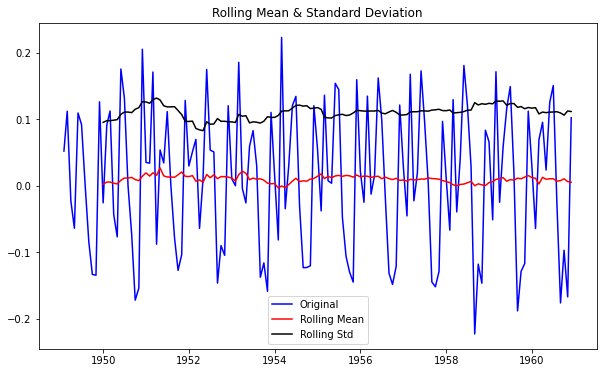

In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

3개의 구성요소로 분석하고 Trend와 Seasonality를 무시하고 residual 분석

<ipython-input-33-f5a7de6bbb4d>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411) #4행 1열 1번째
<ipython-input-33-f5a7de6bbb4d>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(411) #4행 1열 1번째


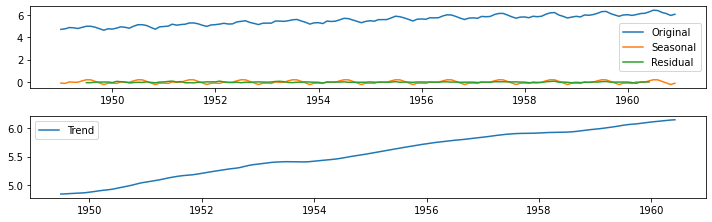

In [ ]:
decomposition=seasonal_decompose(indexedDataset_logScale)

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411) #4행 1열 1번째
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412) #4행 1열 1번째
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411) #4행 1열 1번째
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(411) #4행 1열 1번째
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()
#decomposedLogData = residual
#decomposedLogData.dropna(inplace=True)
#test_stationarity(decomposedLogData)

In [ ]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
#= ["Month","#Passengers"]

rolmean=decomposedLogData.rolling(window=12).mean()
rolstd=decomposedLogData.rolling(window=12).std()
#test_stationarity(decomposedLogData)

Results of ADF Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


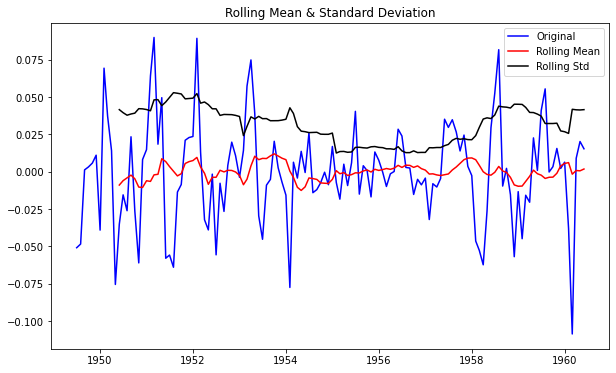

In [ ]:
orig = plt.plot(decomposedLogData, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

print('Results of ADF Test:')
dftest=adfuller(decomposedLogData, autolag='AIC') #default: AIC
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
'#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)


잔차분석

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Text(0.5, 1.0, 'Partial Autocorrelation Function')

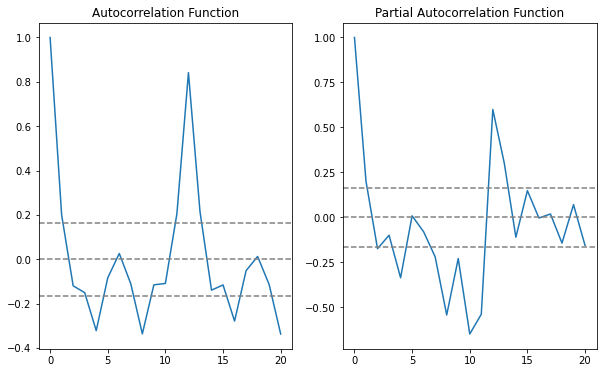

In [ ]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20) #lag: 지연
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

ACF Graph에서 x=2일때 y=0이므로 Q=2 / PACF Graph에서는 x=2일때 y=0이므로 P=2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


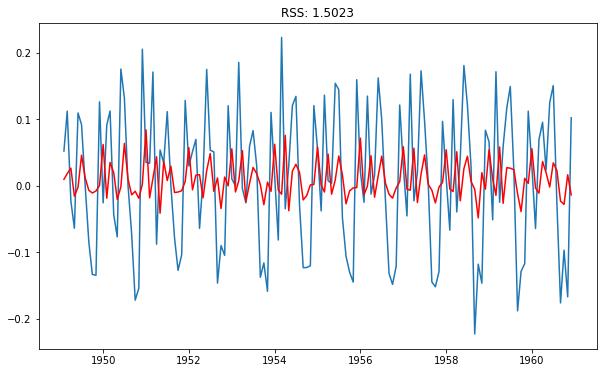

In [ ]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)#log 잔차
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

Plotting MA model


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


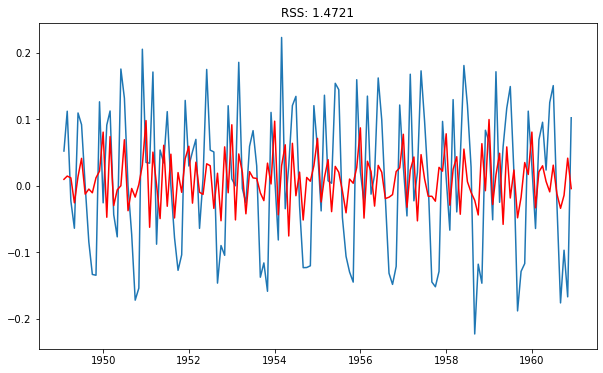

In [ ]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting ARIMA model


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


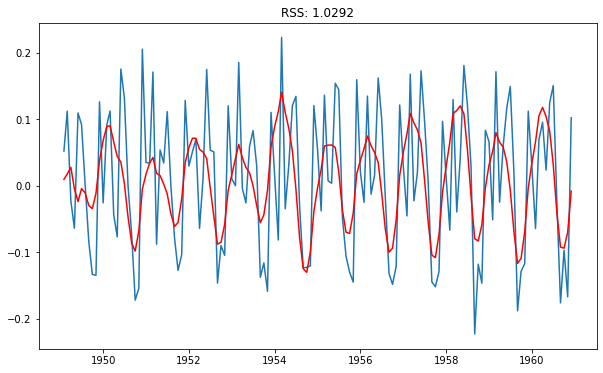

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [ ]:
#Convert to cumulative sum(누적합)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372552
1960-09-01    1.280202
1960-10-01    1.186189
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head() #자연로그 e임

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

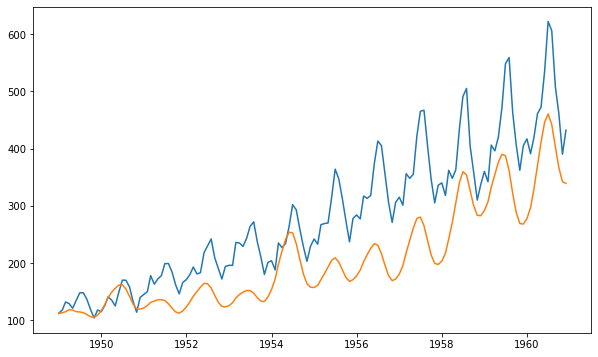

In [ ]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [ ]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


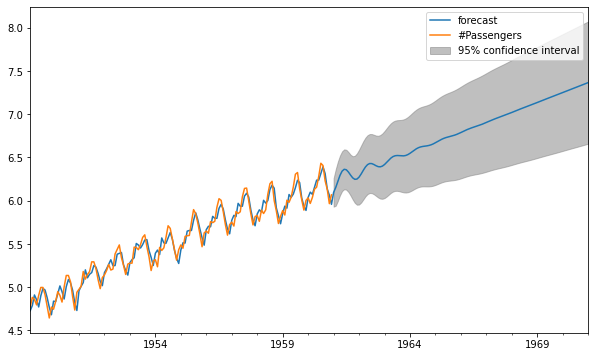

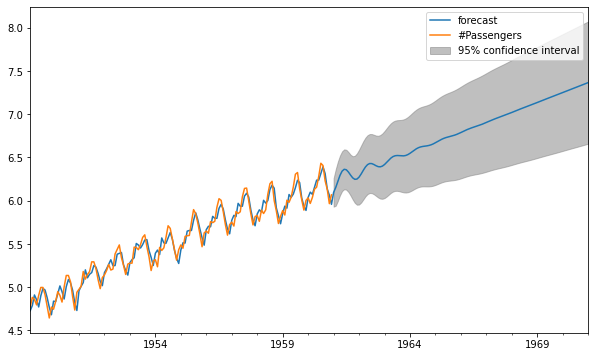

In [ ]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
results_ARIMA.plot_predict(1,264) #위에서 비슷한걸 그래프로 확인해서 예측값 생성
#x=results_ARIMA.forecast(steps=120)

In [ ]:
predictions_ARIMA.to_csv("result.csv")